In the previous notebook, we explored the basics of the `bcs` package which eventually, `retrotide` will call upon to build a chimeric PKS given a target molecule. Since PKSs tend to produce large, structurally complex molecules in an assembly-line fashion, it can often be quite helpful to track the actions of individual domains and modules as well as to connect the addition or transformation of specific carbons in a PKS substrate to specific modules.

In [33]:
from retrotide import retrotide, structureDB

In [34]:
import bcs

In [92]:
from rdkit import Chem
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import AllChem, rdFMCS, rdmolops
from typing import List, Tuple

### Attempting to atom-map PKS products generated from a single loading module

Trying to atom-map PKS products and pinpoint the carbon atoms added as well as transformed by each module can be tricky because PKS chains grow from the bottom to the top. This simply means that when a downstream AT domain picks up an extender unit, typically an acyl-CoA substrate, and the downstream KS adds this extender unit to the PKS substrate bound to the previous module's KS domain, the PKS substrate gets shifted downward. This direction of chain growth introduces the unique problem of aligning the PKS product generated by each module to the carbon atoms added by the loading module. Figure 1 in the following paper provides an excellent illustration of this problem by color-coding the carbons added by each module of the erythromycin-producing PKS: https://doi.org/10.1007/s10295-005-0038-3.

Here, in order to align PKS products to the carbon atom that is farthest from the main PKS assembly (i.e., the first carbon atom within the loading module's product), we start by tracking all atoms in any PKS product with RDKit's internal atom indices. Subsequently, we write a function to select the carbon atom that is farthest from the sulfur radical within a given PKS product. Since the sulfur radical acts as a placeholder for the bond to the ACP domain, we want to align PKS products by selecting the carbon atom that is as far from the ACP domain as possible.

In [89]:
loading_AT_domain = bcs.AT(active = True, substrate = "Hydroxymalonyl-CoA")
loading_module = bcs.Module(domains = {bcs.AT: loading_AT_domain}, loading = True)

mod1_AT_domain = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
module1 = bcs.Module(domains = {bcs.AT: mod1_AT_domain}, loading = False)

mod2_AT_domain = bcs.AT(active = True, substrate = "Malonyl-CoA")
module2 = bcs.Module(domains = {bcs.AT: mod2_AT_domain}, loading = False)

cluster  = bcs.Cluster(modules = [loading_module, module1, module2])

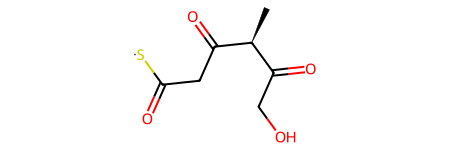

In [90]:
PKS_product = cluster.computeProduct(structureDB)
PKS_product

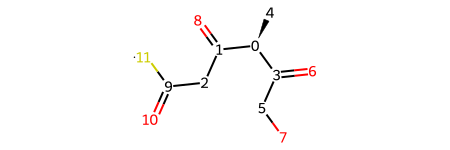

In [91]:
for atom in PKS_product.GetAtoms():
    atom.SetProp("atomLabel", str(atom.GetIdx()))
    
PKS_product

In [87]:
def find_farthest_carbon_from_sulfur(PKS_product: Chem.Mol) -> Tuple[int, int]:
    """
    Takes a PKS product and finds the carbon atom farthest from the sulfur radical, which is a placeholder for bond to ACP protein domain.
    
    Args:
        PKS_product(rdChem.Mol): a mol object representing the PKS product.
    Returns:
        Tuple[int, int]: the index of the carbon atom farthest from the PKS product as well as the corresponding bond distance
    """
    # first, we identify the sulfur atom in the PKS product
    sulfur_idx = None
    for atom in PKS_product.GetAtoms():
        if atom.GetSymbol() == "S":
            sulfur_idx = atom.GetIdx()
            break
    
    if sulfur_idx is None:
        raise ValueError("No sulfur atom found in the molecule.")
    
    # then, grab the atom indices of all carbon atoms in this PKS substrate
    carbon_indices = [atom.GetIdx() for atom in PKS_product.GetAtoms() if atom.GetSymbol() == "C"]
    
    if not carbon_indices:
        raise ValueError("No carbon atoms found in the molecule.")
    
    # compute the shortest path distances from sulfur
    distances = rdmolops.GetDistanceMatrix(PKS_product)
    
    # find the farthest carbon atom
    farthest_carbon_idx = max(carbon_indices, key = lambda idx: distances[sulfur_idx, idx])
    farthest_distance = distances[sulfur_idx, farthest_carbon_idx]
    
    return farthest_carbon_idx, farthest_distance

In [88]:
farthest_carbon_idx, farthest_distance = find_farthest_carbon_from_sulfur(PKS_product)
print(f"Farthest carbon atom index: {farthest_carbon_idx}, Distance: {farthest_distance}")

Farthest carbon atom index: 5, Distance: 6.0


Feel free to try additional chimeric PKS designs above by varying either the number of extension modules, the domain architecture within each extension module, the identity of the starter unit, or the identity of the extender unit/s to convince yourself that our function `find_farthest_carbon_from_sulfur` is able to successfully identify the atom index of the carbon atom that is farthest from the sulfur radical (i.e., the ACP domain). RDKit's function `rdmolops.GetDistanceMatrix` plays a crucial role in helping to identify this carbon atom by generating a matrix of bond distances between each constituent atom within a `Chem.Mol` object.

Our next step in the process of aligning PKS product molecules with each other is now going to be to replace one of the hydrogens on the carbon atom identified to be farthest from the sulfur radical with a fluorine. This newly attached fluorine atom will then be replaced again with a massive -CoA group but this intermediate step of attaching the fluorine atom first helps us distinguish this particular carbon atom from all others within a PKS product. SMARTS templates have been written with RDKit to replace the fluorine atom with -CoA, and then to finally detach the -CoA and reproduce the PKS product.

In [58]:
def add_fluorine_to_farthest_carbon(PKS_product: Chem.Mol, farthest_carbon_idx: int) -> Chem.Mol: 
    """
    Adds a fluorine atom to the carbon atom previously identified as farthest from the sulfur radical (which represents bond to ACP domain).
    
    Args:
        PKS_product(rdChem.Mol): a mol object representing the PKS product.
        farthest_carbon_idx(int): the internal RDKit atom index of the carbon that is the farthest away frm the sulfur radical.
        
    Returns:
        rdChem.Mol: the updated molecule with the fluorine atom added to the specified carbon atom.
    """

    editable_mol = Chem.EditableMol(PKS_product)
    fluorine_idx = editable_mol.AddAtom(Chem.Atom("F"))

    # add a bond between the specific carbon atom (e.g., index 1) and fluorine
    editable_mol.AddBond(farthest_carbon_idx, fluorine_idx, Chem.rdchem.BondType.SINGLE)

    PKS_product_w_F = editable_mol.GetMol()
    
    return PKS_product_w_F

In [59]:
def replace_fluorine_with_CoA(PKS_product_w_F: Chem.Mol) -> Chem.Mol:
    """
    Replaces the fluorine atom with a -CoA group to help in aligning molecules for downstream maximum common substructure comparisons.
    
    Args:
         PKS_product_w_F (rdChem.Mol): a mol object representing the PKS product with fluorine attached.
        
    Returns:
        rdChem.Mol: a mol object representing the PKS product with -CoA attached instead of fluorine.
    """
    
    attach_CoA_rxn_pattern = '[C,c:1]-[F:2].[S:3]>>[C,c:1]-[S:3].[F:2]'
    attach_CoA_rxn = AllChem.ReactionFromSmarts(attach_CoA_rxn_pattern)
    
    CoA_group = Chem.MolFromSmiles('CC(C)(COP(=O)(O)OP(=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)[C@H](C(=O)NCCC(=O)NCCS)O')
    
    for atom in CoA_group.GetAtoms():
        atom.SetProp("atomLabel","X")
        
    PKS_product_w_CoA = attach_CoA_rxn.RunReactants((PKS_product_w_F, CoA_group))[0][0]
    return PKS_product_w_CoA

In [60]:
def detach_CoA_frm_labelled_PKS_product(PKS_product_w_CoA: Chem.Mol):
    detach_CoA_rxn_pattern = '[C,c:1]-[S:3]-[C:4]-[C:5]-[N:6]>>[C,c:1].[S:3]-[C:4]-[C:5]-[N:6]'
    detach_CoA_rxn = AllChem.ReactionFromSmarts(detach_CoA_rxn_pattern)
    labelled_PKS_product = detach_CoA_rxn.RunReactants((PKS_product_w_CoA,))[0][0]
    return labelled_PKS_product

In [63]:
farthest_carbon_idx, farthest_distance = find_farthest_carbon_from_sulfur(PKS_product)
PKS_product_w_F = add_fluorine_to_farthest_carbon(PKS_product, farthest_carbon_idx)
PKS_product_w_CoA = replace_fluorine_with_CoA(PKS_product_w_F)

The C-F bond formed with the carbon atom that is farthest from the sulfur radical helps distinguish this particular carbon atom from all others and later enables us to tack on a huge -CoA group to this carbon atom:

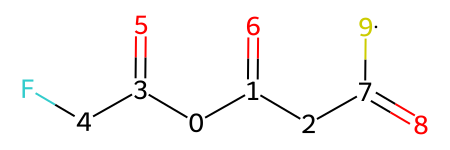

In [68]:
PKS_product_w_F

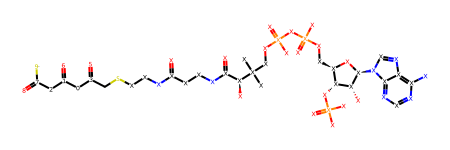

In [69]:
PKS_product_w_CoA

With another SMARTS template, this -CoA group can now be detached to regenerate the original PKS product: 

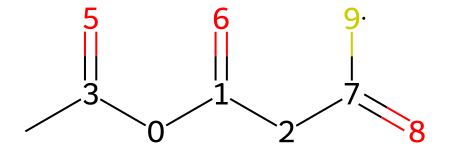

In [70]:
detach_CoA_frm_labelled_PKS_product(PKS_product_w_CoA)

In [27]:
# label all atoms in the PKS product generated by an initial loading module

LM_AT_domain = bcs.AT(active = True, substrate = "benz")
LM = bcs.Module(domains = {bcs.AT: LM_AT_domain}, loading = True)

LM_cluster  = bcs.Cluster(modules = [LM])
LM_product = LM_cluster.computeProduct(structureDB)

farthest_carbon_idx, _ = find_farthest_carbon_from_sulfur(LM_product)
LM_product_w_F = add_fluorine_to_farthest_carbon(LM_product, farthest_carbon_idx)
LM_product_w_CoA = replace_fluorine_with_CoA(LM_product_w_F)
LM_product_wo_CoA = detach_CoA_frm_labelled_PKS_product(LM_product_w_CoA)

for atom in LM_product_wo_CoA.GetAtoms():
    if atom.HasProp("atomLabel") == 0:
        atom.SetProp("atomLabel","LM")

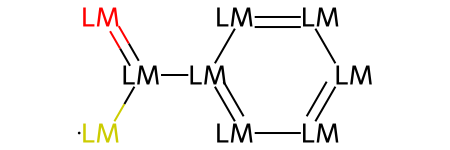

In [28]:
LM_product_wo_CoA

In [74]:
# label all atoms in the PKS product generated by the first extension module
# we can do this by finding substructure matches between the module 1 product and loading module product

### Define the loading module and label carbons
LM_AT_domain = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
LM = bcs.Module(domains = {bcs.AT: LM_AT_domain}, loading = True)
LM_cluster = bcs.Cluster(modules = [LM])
LM_product = LM_cluster.computeProduct(structureDB)

farthest_carbon_idx, _ = find_farthest_carbon_from_sulfur(LM_product)
LM_product_w_F = add_fluorine_to_farthest_carbon(LM_product, farthest_carbon_idx)
LM_product_w_CoA = replace_fluorine_with_CoA(LM_product_w_F)
LM_product_wo_CoA = detach_CoA_frm_labelled_PKS_product(LM_product_w_CoA)

for atom in LM_product_wo_CoA.GetAtoms():
    if atom.HasProp("atomLabel") == 0:
        atom.SetProp("atomLabel","LM")

### Define the first extension module
Mod1_AT_domain = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
Mod1 = bcs.Module(domains = {bcs.AT: Mod1_AT_domain}, loading = False)
Mod1_cluster = bcs.Cluster(modules = [LM ,Mod1])
Mod1_product = Mod1_cluster.computeProduct(structureDB)

farthest_carbon_idx, _ = find_farthest_carbon_from_sulfur(Mod1_product)
Mod1_product_w_F = add_fluorine_to_farthest_carbon(Mod1_product, farthest_carbon_idx)
Mod1_product_w_CoA = replace_fluorine_with_CoA(Mod1_product_w_F)

In [75]:
# find substructure matches between the module 1 product and loading module product while both have a -CoA attached
# the large -CoA group attached to the carbon farthest from the sulfur radical (i.e. ACP placeholder) helps align the various PKS products
substruct_result = rdFMCS.FindMCS([LM_product_w_CoA, Mod1_product_w_CoA],
                                  timeout = 1,
                                  matchChiralTag = False,
                                  bondCompare = Chem.rdFMCS.BondCompare.CompareOrderExact)

match = Mod1_product_w_CoA.GetSubstructMatch(substruct_result.queryMol)

# for each atom in the first extension module's product
for atom in Mod1_product_w_CoA.GetAtoms():
    
    # any atoms not in the MCS match were added on by the first extension module
    if atom.GetIdx() not in match:
        if atom.HasProp("atomLabel") == 0:
            atom.SetProp("atomLabel", "M1")
            
    # any atoms present in the MCS match were initialized by the loading module
    if atom.GetIdx() in match:
        if atom.HasProp("atomLabel") == 0:
            atom.SetProp("atomLabel", "LM")
            
# finally, detach the -CoA group from the first extension module
Mod1_product_wo_CoA = detach_CoA_frm_labelled_PKS_product(Mod1_product_w_CoA)

# any unlabelled atoms in the final product were placed by the loading module
for atom in Mod1_product_wo_CoA.GetAtoms():
    if atom.HasProp("atomLabel")==0:
        atom.SetProp("atomLabel", "LM")

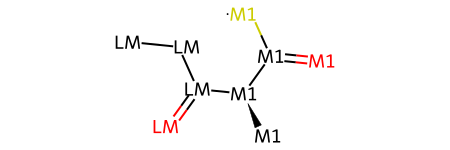

In [76]:
Mod1_product_wo_CoA

### Putting the full atom mapping algorithm together

In [114]:
def create_atom_maps(cluster: bcs.Cluster) -> Chem.Mol:
    
    modules_list = cluster.modules
    atom_labels_list = [f"LM" if i == 0 else f"M{i}" for i in range(len(modules_list))]
    labelled_mols_list = []
    
    for module_num in range(0,len(modules_list)):
        
        # for the loading module specifically
        if module_num == 0:
            
            # generate the loading module product
            cluster = bcs.Cluster(modules = [ modules_list[0] ]) # input to bcs.Cluster is list of modules
            LM_product = cluster.computeProduct(structureDB)
            
            # attach a florine atom to the farthest carbon from the sulfur radical (ACP placeholder)
            farthest_carbon_idx, _ = find_farthest_carbon_from_sulfur(LM_product)
            LM_product_w_F = add_fluorine_to_farthest_carbon(LM_product, farthest_carbon_idx)
            
            # then swap the florine for a -CoA group so all PKS products can be easily aligned
            LM_product_w_CoA = replace_fluorine_with_CoA(LM_product_w_F)
            
            for atom in LM_product_w_CoA.GetAtoms():
                if atom.HasProp("atomLabel") == 0:
                    atom.SetProp("atomLabel","LM")
                    
            labelled_mols_list.append(LM_product_w_CoA)
            
        else:
            
            current_modules_sublist = modules_list[0:(module_num+1)]
            atom_labels_sublist = atom_labels_list[0:(module_num+1)]
            current_cluster = bcs.Cluster(modules = current_modules_sublist)
            current_product = current_cluster.computeProduct(structureDB)
            
            # similar to the loading module, attach a fluorine to the farthest carbon atom from ACP
            farthest_carbon_idx, _ = find_farthest_carbon_from_sulfur(current_product)
            current_product_w_F = add_fluorine_to_farthest_carbon(current_product, farthest_carbon_idx)
            current_product_w_CoA = replace_fluorine_with_CoA(current_product_w_F)
            
            # for each previous_product starting from up until the previous module
            for i, previous_product_w_CoA in enumerate(labelled_mols_list[::-1]):
                
                MCS_result = rdFMCS.FindMCS([current_product_w_CoA, previous_product_w_CoA], 
                                            timeout = 1,
                                            matchChiralTag = False,
                                            bondCompare = Chem.rdFMCS.BondCompare.CompareOrderExact)
                
                match = current_product_w_CoA.GetSubstructMatch(MCS_result.queryMol)
                
                label = atom_labels_sublist[::-1][i]
                
                for atom in current_product_w_CoA.GetAtoms():
                    if atom.GetIdx() not in match:
                        if atom.HasProp("atomLabel") == 0:
                            atom.SetProp("atomLabel", label)
                            
            labelled_mols_list.append(current_product_w_CoA)
            
    # for all the labelled PKS substrates, detach the -CoA group
    final_mols_list = [detach_CoA_frm_labelled_PKS_product(mol) for mol in labelled_mols_list]
    
    # finally, label atoms that were previously attached to the -CoA group with "LM"
    for mol in final_mols_list:
        for atom in mol.GetAtoms():
            if atom.HasProp("atomLabel")==0:
                atom.SetProp("atomLabel","LM")
                
    return final_mols_list

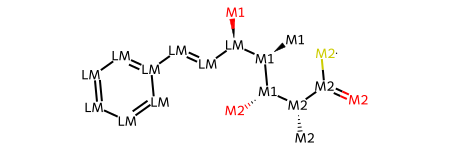

In [117]:
LM_AT_domain = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
LM = bcs.Module(domains = {bcs.AT: LM_AT_domain}, loading = True)

M1_AT_domain = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
M1_KR_domain = bcs.KR(active = True, type = "B1")
M1 = bcs.Module(domains = {bcs.AT: M1_AT_domain,
                           bcs.KR: M1_KR_domain}, loading = False)

M2_AT_domain = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
M2_KR_domain = bcs.KR(active = True, type = "B1")
M2 = bcs.Module(domains = {bcs.AT: M2_AT_domain,
                           bcs.KR: M2_KR_domain}, loading = False)

PKS_cluster = bcs.Cluster(modules = [LM, M1, M2])

In [91]:
create_atom_maps(PKS_cluster)

[["AT{'substrate': 'prop'}", 'loading: True']]